In [1]:
from notes.strategy.logic.strategies import XOverStrat, Benchmark, BollingerMeanReversion, XOverStrat
from notes.strategy.logic.indicators import BollingerBand, TradingRange
import notes.strategy.logic.indicators as indicator
import notes.strategy.logic.strategies as strategy
from ib_insync import *
import scripts.trend_viewer
import pandas as pd
util.startLoop()

ib = IB()
# port = 7496
port = 4001
ib.connect('127.0.0.1', port, clientId=0)

<IB connected to 127.0.0.1:4001 clientId=0>

In [2]:
def ib_get_historical(symbol, sec_type, duration, interval, use_rth=True): 
    contracts = ib.reqContractDetails(Contract(symbol=symbol, secType=sec_type, includeExpired=False))[0]
    contract = contracts.contract
    bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=interval,
        whatToShow='TRADES' if symbol not in ['BTC', 'ETH'] else 'AGGTRADES',
        useRTH=use_rth,
        formatDate=1,
        keepUpToDate=False
    )
    prices = util.df(bars)
    prices.index = prices.date 
    prices = prices.drop(columns=['date'])
    return prices


In [3]:
# price = ib_get_historical('BTC', 'CRYPTO', '5 Y', '1 day')
price = ib_get_historical('SPY', 'STK', '1 Y', '30 mins')

In [4]:
bench = Benchmark()
bench.update(price['close'].copy())

In [5]:
bench.stats.expectancy()

date
2023-05-03 09:30:00-04:00         NaN
2023-05-03 10:00:00-04:00   -0.001797
2023-05-03 10:30:00-04:00   -0.001567
2023-05-03 11:00:00-04:00   -0.001256
2023-05-03 11:30:00-04:00   -0.000650
                               ...   
2024-05-01 11:30:00-04:00    0.000062
2024-05-01 12:00:00-04:00    0.000063
2024-05-01 12:30:00-04:00    0.000062
2024-05-01 13:00:00-04:00    0.000063
2024-05-01 13:30:00-04:00    0.000063
Length: 3247, dtype: float64

In [6]:
xover = XOverStrat(50, 200)
xover.update(price['close'].copy())
xover.log
xover.stats.expectancy()

date
2023-05-03 09:30:00-04:00         NaN
2023-05-03 10:00:00-04:00         NaN
2023-05-03 10:30:00-04:00         NaN
2023-05-03 11:00:00-04:00         NaN
2023-05-03 11:30:00-04:00         NaN
                               ...   
2024-05-01 11:30:00-04:00   -0.000060
2024-05-01 12:00:00-04:00   -0.000060
2024-05-01 12:30:00-04:00   -0.000060
2024-05-01 13:00:00-04:00   -0.000060
2024-05-01 13:30:00-04:00   -0.000059
Length: 3247, dtype: float64

In [7]:
strat = strategy.Custom(
    indicators=[
        TradingRange(high_band_pct=.40, low_band_pct=.61, window=200),
        indicator.Regime(),
    ]
)
strat.update(price['close'].copy())

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()


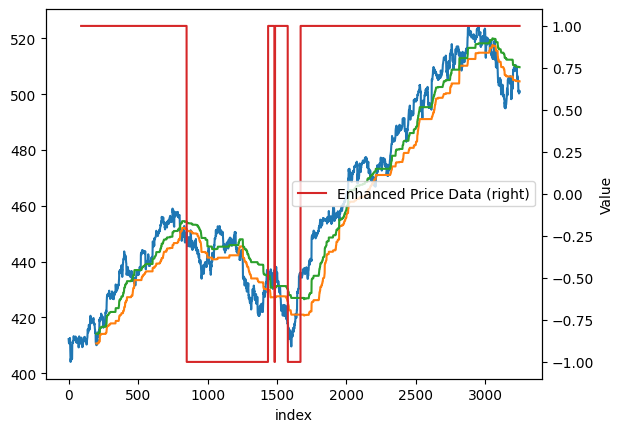

In [8]:
import pandas as pd


import matplotlib.pyplot as plt

strat.price['close'].reset_index(drop=True).plot(label='Close')
strat.indicators[0].upper.reset_index(drop=True).plot(label='Upper')
strat.indicators[0].lower.reset_index(drop=True).plot(label='Lower')
strat.indicators[1].value.enhanced_price_data.rg.plot(secondary_y=True, label='Enhanced Price Data')



plt.xlabel('Index')
plt.ylabel('Value')

plt.legend()
plt.show()
